In [309]:
import re
import os
import sys
import warnings
import pandas as pd
import time
from openai import OpenAI

import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
sys.path.append('/home/or/dev/latin_music_statistics/crawler/data_dir')
sys.path.append(os.path.abspath(os.path.join(parent_dir, 'statistics_dir')))

from config import *

sys.path.append(parent_dir)
sys.path.append(os.path.abspath(os.path.join(parent_dir, "statistics_dir")))

from statistics_dir.statistics import *
from conclusion_text import *

client = OpenAI(api_key = OPENAI_KEY)
df = pd.read_csv('/home/or/dev/latin_music_statistics/crawler/data_dir/final_data.csv')
general_df = pd.read_csv('/home/or/dev/latin_music_statistics/crawler/data_dir/themes/general_themes.csv')
general_df = general_df.drop(general_df.filter(regex='Unnamed').columns, axis=1)

In [150]:
general_df

,general_theme,general_theme_emb
0,Love and Relationships,"[0.06247195601463318, -0.026712730526924133, -..."
1,Heartbreak and Loss,"[0.06000248342752457, -0.008102118968963623, -..."
2,Celebration and Joy,"[-0.011667180806398392, 0.0015809942269697785,..."
3,Nostalgia and Reflection,"[-0.0027844898868352175, 0.019363638013601303,..."
4,Self-Discovery and Identity,"[0.03952469304203987, -0.042790673673152924, -..."
5,Wealth and Materialism,"[-0.013634332455694675, -8.126136526698247e-05..."
6,Resilience and Determination,"[0.006822242401540279, -0.013098275288939476, ..."
7,Violence and Explicit Content,"[0.02615818940103054, -0.06956687569618225, 0...."
8,Toxic Relationships,"[0.039800748229026794, -0.031918685883283615, ..."
9,Friendship and Support,"[0.010505983605980873, -0.02319970354437828, -..."


In [148]:
for idx, row in  df[df['selected_sentiment'] == 'negative'][df['general_theme'] == 'Hope and Recovery'].iterrows():
    print(row['title'],row['sentiment'])
    print('Theme: ',row['theme'])
    print('Theme: ',row['general_theme'])
    #print('Theme(openai): ',row['openai_general_theme'])
    print('\n\n\n')
    print('-' * 100)
    print('\n\n\n')

    if idx >30:
        break

LA FAMA {'neutral': 0.2, 'positive': 0.05, 'negative': 0.75}
Theme:  The deceptive and transient nature of fame, and how it can become an obsession that ultimately causes personal harm and mistrust.
Theme:  Hope and Recovery




----------------------------------------------------------------------------------------------------




Eres Mía {'neutral': 0.05, 'positive': 0.2, 'negative': 0.75}
Theme:  Possessive love and jealousy, with a focus on claiming ownership over a past lover despite her current relationship.
Theme:  Hope and Recovery




----------------------------------------------------------------------------------------------------




Deja vu {'neutral': 0.0, 'positive': 0.0, 'negative': 1.0}
Theme:  The emotional struggle and skepticism towards love after experiencing repeated heartbreak and disillusionment.
Theme:  Hope and Recovery




----------------------------------------------------------------------------------------------------




Imitadora {'neutral': 0.1, 'pos

/tmp/ipykernel_4141/1269736680.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for idx, row in  df[df['selected_sentiment'] == 'negative'][df['general_theme'] == 'Hope and Recovery'].iterrows():


In [131]:
# general_df['theme_embeddings'] = ''

In [133]:
import time
import pandas as pd

def get_openai_embbdings(df, col_text_name, col_emb_name):
    # Define constants
    MAX_RETRIES = 5
    EVERY_QUERY_DELAY = 0  # Delay in seconds
    FAILED_RETRY_DELAY = 30  # Delay in seconds
    
    if col_emb_name in df.columns:
        selected_df = df[df[col_emb_name] == '']
    else:  
        df[col_emb_name] = ''
        selected_df = df
    
    embeddings = []
    
    # Loop through each row in the DataFrame
    for index, row in selected_df.iterrows():
        theme = row[col_text_name]
        attempt = 0
        while attempt < MAX_RETRIES:
            try:
                response = client.embeddings.create(
                    model='text-embedding-3-large',
                    input=theme,
                    encoding_format="float"
                )
                embedding = response.data[0].embedding
                df.at[index, col_emb_name] = embedding
                embeddings.append(embedding)
                break  # Exit the retry loop if successful
            except Exception as e:
                print(f"An error occurred for index {index}: {e}")
                attempt += 1
                if attempt >= MAX_RETRIES:
                    embedding = ''  # Assign None or some default value if the request fails after retries
                    df.at[index, col_emb_name] = embedding
                    embeddings.append(embedding)
                else:
                    # Sleep before retrying
                    sleep_delay = FAILED_RETRY_DELAY * (attempt + 1)
                    time.sleep(sleep_delay)
                    print(f"Retrying index {index} after {sleep_delay} seconds...")
    
        # Optional: Sleep to avoid hitting rate limits
        time.sleep(EVERY_QUERY_DELAY)  # Adjust based on API rate limits
        print(f"Processed index: {index}")

a_df = get_openai_embbdings(df, 'theme', 'theme_embeddings')
# a_df_gen = get_openai_embbdings(general_df, 'general_theme', 'theme_embeddings')

Processed index: 0
Processed index: 1
Processed index: 2
Processed index: 3
Processed index: 4
Processed index: 5
Processed index: 6
Processed index: 7
Processed index: 8


KeyboardInterrupt: 

In [121]:
general_df

,Unnamed: 0,general_theme,general_theme_emb,theme_embeddings
0,0,Love and Relationships,"[0.06247195601463318, -0.026712730526924133, -...","[0.012426764, -0.04396962, -0.014187113, 0.033..."
1,1,Heartbreak and Loss,"[0.06000248342752457, -0.008102118968963623, -...","[0.002748956, -0.0014275558, -0.014183663, 0.0..."
2,2,Celebration and Joy,"[-0.011667180806398392, 0.0015809942269697785,...","[0.078400634, 0.004165951, -0.01338243, 0.0314..."
3,3,Nostalgia and Reflection,"[-0.0027844898868352175, 0.019363638013601303,...","[0.0269419, 0.011847117, -0.03448929, -0.00559..."
4,4,Self-Discovery and Identity,"[0.03952469304203987, -0.042790673673152924, -...","[0.031929754, -0.03660433, -0.015515906, 0.047..."
5,5,Wealth and Materialism,"[-0.013634332455694675, -8.126136526698247e-05...","[0.014195532, 0.02358439, 0.015608482, 0.05577..."
6,6,Resilience and Determination,"[0.006822242401540279, -0.013098275288939476, ...","[0.034874413, 0.037645496, 0.050852377, 0.0782..."
7,7,Violence and Explicit Content,"[0.02615818940103054, -0.06956687569618225, 0....","[0.029449549, 0.056740962, -0.050446402, -0.00..."
8,8,Toxic Relationships,"[0.039800748229026794, -0.031918685883283615, ...","[-0.020527458, 0.019356795, -0.024502272, 0.06..."
9,9,Friendship and Support,"[0.010505983605980873, -0.02319970354437828, -...","[-0.002515492, -0.021081557, 0.0065159914, 0.0..."


In [95]:
def find_closest_embeddings(df, 
                            general_themes_df, 
                            df_t_emb_name = 'theme_emb',
                            gen_t_txt_name = 'general_theme',
                            df_gen_emb_name = 'general_theme_emb',
                            df_tgt_t_name = 'general_theme'):
    # Assuming embeddings are stored as lists or numpy arrays in the DataFrame columns

    for idx, theme_row in df.iterrows():
        try:
            current_embedding = eval(theme_row[df_t_emb_name])
        except TypeError as e:
            current_embedding = theme_row[df_t_emb_name]
            
        vector1 = np.array(current_embedding).reshape(1, -1)

        # Initialize variables to find the closest match
        min_dist = float('inf')
        closest_theme = None
        
        # Iterate over general_themes_df to find the closest match
        for _, general_row in general_themes_df.iterrows():
            try:
                general_embedding = eval(general_row[df_gen_emb_name])
            except TypeError as e:
                general_embedding = general_row[df_gen_emb_name]
                
            general_theme = general_row[gen_t_txt_name]
            
            vector2 = np.array(general_embedding).reshape(1, -1)
            
            # Compute cosine similarity (distance) between the current embedding and the general embeddings
            dist = cosine_similarity(vector1, vector2)

            # Update closest match if a smaller distance is found
            if dist < min_dist:
                min_dist = dist
                closest_theme = general_theme
        
        # Store the closest theme in the df
        df.at[idx, df_tgt_t_name] = closest_theme

    return df

In [ ]:
# Add embeddings to the DataFrame
def get_embedding(text):
    response = client.embeddings.create(
        model=OPENAI_EMBEDDINGS_MODEL,
        input=text,
        encoding_format="float"
    )
    return response.data[0].embedding

def add_embeddings_to_df(df):
    df['theme_embeddings'] = df['theme'].apply(get_embedding)
    return df

df['theme_embeddings'] = ''
df_with_embeddings = add_embeddings_to_df(df)

In [165]:
def dist_single_sentiment(df, col):
    sentiment_counts = df[col].value_counts()

    total_df = len(df)
    
    artist_percentages = (sentiment_counts / total_df) * 100

    # Create a DataFrame with the statistics
    stats_df = pd.DataFrame({
        'Frequency': sentiment_counts,
        'Percentage': artist_percentages
    }).reset_index()
    stats_df.columns = ['Sentiment', 'Frequency', 'Percentage']
    stats_df = stats_df.sort_values(by='Sentiment', ascending=False)

    return stats_df

In [273]:
df = pd.read_csv('/home/or/dev/latin_music_statistics/crawler/data_dir/final_data.csv')
df['all_artists'] = df['all_artists'].apply(lambda x: eval(x))
df_all_artist = df.explode("all_artists")
df_artist = df_all_artist[df_all_artist["all_artists"] == 'Aventura']
artist_stat = calculate_counts(df_artist, "all_artists")
sentiment_single_dist = dist_single_sentiment(df, "selected_sentiment")


In [304]:
df_expanded = df.explode('all_artists')
selected_df = df_expanded[df_expanded['all_artists'] == 'Frank Reyes']


In [305]:
len(selected_df)/len(df)

0.09608540925266904

In [259]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_counts_with_sentiment(df, col, sentiment_col):
    # Expand the DataFrame
    df_expanded = df.explode(col)

    # Calculate frequency and percentage for the main column
    all_counts = df_expanded[col].value_counts()
    total_records = len(df)
    percentages = (all_counts / total_records) * 100

    # Create DataFrame for general theme statistics
    stats_df = pd.DataFrame({
        col: all_counts.index,
        'Frequency': all_counts.values,
        'Percentage': percentages.values
    })

    # Create nested dictionary to hold sentiments within each category
    nested_dict = {}
    for col_value in stats_df[col]:
        selected_df = df_expanded[df_expanded[col] == col_value]
        sentiment_counts = selected_df[sentiment_col].value_counts()

        # Ensure the sentiment order is always "Negative", "Positive", "Neutral"
        ordered_sentiments =  list(sentiment_counts.keys())
        ordered_counts = {sentiment: sentiment_counts.get(sentiment, 0) for sentiment in ordered_sentiments}

        nested_dict[col_value] = {
            'Frequency': int(all_counts[col_value]),
            'Percentage': round(percentages[col_value], 2),
            'Sentiments': ordered_counts
        }
    
    return stats_df, nested_dict

# def plot_top_counts_with_sentiment(df, nested_dict, x_label, title, annot_bar=True, rotation=0, samples_num=10):
#     # Sort DataFrame to get the top values

#     sorted_data = dict(sorted(nested_dict.items(), key=lambda item: item[1]['Frequency'], reverse=True))
#     top_n_samples = dict(list(sorted_data.items())[:samples_num])

#     # Initialize plot
#     fig, ax = plt.subplots()

#     # Set colors for different sentiments
#     sentiment_colors = {
#         'positive': 'green',
#         'negative': 'red',
#         'neutral': 'gray'
#     }

#     # Plot each sentiment for the top categories
#     for idx, row in top_df.iterrows():
#         col_name = row[df.columns[0]]  # Get the theme name
#         base_value = 0  # Start from the bottom for each bar

#         # Get the sentiment data from the nested dictionary in the desired order
#         if col_name in nested_dict:
#             sentiments = nested_dict[col_name]['Sentiments']

#             for sentiment in ['negative', 'positive', 'neutral']:  # Plot in the specified order
#                 count = sentiments[sentiment]

#                 # Plot each sentiment as a stacked bar
#                 ax.bar(
#                     col_name, count,
#                     bottom=base_value,
#                     color=sentiment_colors.get(sentiment, 'blue'),  # Use default color if sentiment not found
#                     label=sentiment if idx == 0 else ""  # Label only the first occurrence for legend
#                 )

#                 # Annotate each sentiment's count in the middle of its segment
#                 if annot_bar and count > 0:
#                     ax.text(
#                         col_name, base_value + count / 2,  # Middle of the segment
#                         f"{count}",  # Annotate with the count
#                         ha='center', va='center', color='white'  # Adjust text color for visibility
#                     )

#                 base_value += count  # Update the base for the next sentiment

#     # Configure plot settings
#     ax.set_xlabel(x_label)
#     ax.set_ylabel("Count")
#     ax.set_title(title)

#     # Show legend
#     ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

#     if rotation != 0:
#         plt.xticks(rotation=rotation)

#     plt.tight_layout()

#     plt.show()

# Example usage
gt_stat, nested_dict = calculate_counts_with_sentiment(df, "general_theme", "selected_sentiment")
# plot_top_counts_with_sentiment(gt_stat, nested_dict, "General Theme", "Top General Themes with Sentiments")


In [310]:
  ( artist_stat,
      norm_words_stat,
      theme_stat,
      sentiment_single_dist,
      sentiment_avg_dist,
      avg_words_per_song ) = general_statistics(df)

In [313]:
sentiment_single_dist['Sentiment']

1    positive
2     neutral
0    negative
Name: Sentiment, dtype: object

In [316]:
sentiment_single_dist

,Sentiment,Frequency,Percentage
1,positive,325,38.552788
2,neutral,22,2.609727
0,negative,496,58.837485


In [315]:
sentiment_colors = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'yellow'
}

# Map sentiment to colors
colors = sentiment_single_dist['Sentiment'].map(sentiment_colors)
colors

1     green
2    yellow
0       red
Name: Sentiment, dtype: object

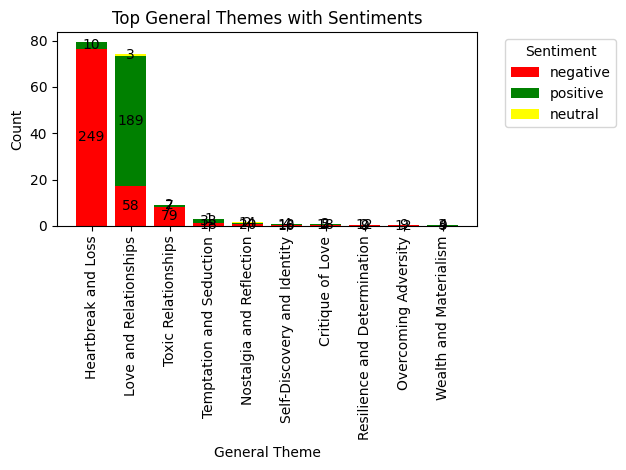

In [287]:
def plot_top_samples_with_sentiments(nested_dict, x_label, title, annot_bar=True, rotation=0, samples_num=10):
    sorted_data = dict(sorted(nested_dict.items(), key=lambda item: item[1]['Frequency'], reverse=True))

    # Taking the top N samples
    top_n_samples = dict(list(sorted_data.items())[:samples_num])
    
    # Initialize plot
    fig, ax = plt.subplots()
    
    # Set colors for different sentiments
    sentiment_colors = {
        'positive': 'green',
        'negative': 'red',
        'neutral': 'yellow'
    }
    sentiment_labels = ['negative', 'positive', 'neutral']
    # Plot each sentiment for the top categories
    for key_name_, stats in top_n_samples.items():
        base_value = 0  # Start from the bottom for each bar

        # Get the sentiment data from the current theme
        sentiments = stats['Sentiments']

        for sentiment in ['negative', 'positive', 'neutral']:  # Plot in the specified order
            count = sentiments.get(sentiment, 0)  # Default to 0 if sentiment not found
            sentiment_percentage = (count / 100)* stats['Percentage']


            # Plot each sentiment as a stacked bar
            if count > 0:  # Only plot non-zero counts
                bar = ax.bar(
                    key_name_, sentiment_percentage,
                    bottom=base_value,
                    color=sentiment_colors.get(sentiment, 'blue'),  # Use default color if sentiment not found
                )

                # Annotate each sentiment's count in the middle of its segment
                if annot_bar:
                    ax.text(
                        key_name_, base_value + sentiment_percentage / 2,  # Middle of the segment
                        f"{count}",  # Annotate with the count
                        ha='center', va='center', color='black'  # Adjust text color for visibility
                    )
                    
                base_value += sentiment_percentage  # Update the base for the next sentiment

    for sentiment in sentiment_labels:
        ax.bar(key_name_, 0,  # Dummy bar for the legend
         color=sentiment_colors[sentiment],
         label=sentiment)
                
                     
    # Configure plot settings
    ax.set_xlabel(x_label)
    ax.set_ylabel("Count")
    ax.set_title(title)

    # ax.set_label(['Negative', 'Positive', 'Neutral'])
    # Show legend
    ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

    if rotation != 0:
        plt.xticks(rotation=rotation)

    plt.tight_layout()

    plt.show()
    
gt_stat, nested_dict = calculate_counts_with_sentiment(df, "general_theme", "selected_sentiment")
plot_top_samples_with_sentiments(nested_dict, "General Theme", "Top General Themes with Sentiments", rotation = 90)


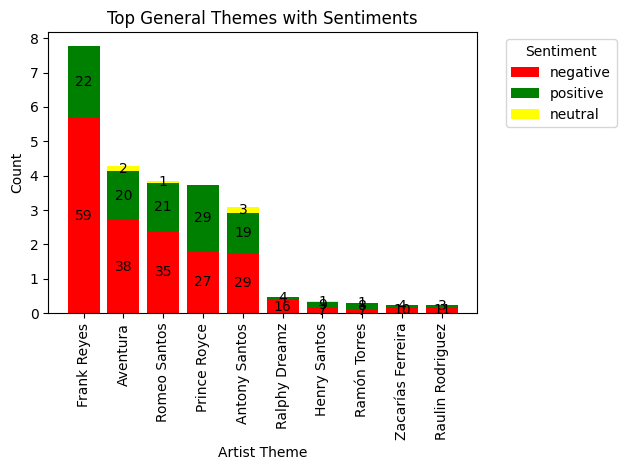

In [285]:
gt_stat, nested_dict = calculate_counts_with_sentiment(df, "all_artists", "selected_sentiment")
plot_top_samples_with_sentiments(nested_dict, "Artist Theme", "Top General Themes with Sentiments", rotation = 90)


In [265]:
df.columns

Index(['Unnamed: 0', 'url', 'title_with_artists', 'title', 'artists',
       'featured_artists', 'lyrics', 'clean_lyrics', 'norm_words',
       'norm_w_len', 'sentiment', 'selected_sentiment', 'all_artists', 'theme',
       'theme_emb', 'general_theme'],
      dtype='object')

In [229]:
sorted(nested_dict, key=lambda x: x['Percentage'])

TypeError: string indices must be integers, not 'str'

In [226]:
# Sort DataFrame to get the top values
top_df = nested_dict.sort_values(by="Percentage", ascending=False).head(samples_num)

# Initialize plot
fig, ax = plt.subplots()

# Set colors for different sentiments
sentiment_colors = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'gray'
}

# Plot each sentiment for the top categories
for idx, row in top_df.iterrows():
    col_name = row[df.columns[0]]  # Get the theme name
    base_value = 0  # Start from the bottom for each bar

    # Get the sentiment data from the nested dictionary in the desired order
    if col_name in nested_dict:
        sentiments = nested_dict[col_name]['Sentiments']

        for sentiment in ['negative', 'positive', 'neutral']:  # Plot in the specified order
            count = sentiments[sentiment]

            # Plot each sentiment as a stacked bar
            ax.bar(
                col_name, count,
                bottom=base_value,
                color=sentiment_colors.get(sentiment, 'blue'),  # Use default color if sentiment not found
                label=sentiment if idx == 0 else ""  # Label only the first occurrence for legend
            )

            # Annotate each sentiment's count in the middle of its segment
            if annot_bar and count > 0:
                ax.text(
                    col_name, base_value + count / 2,  # Middle of the segment
                    f"{count}",  # Annotate with the count
                    ha='center', va='center', color='white'  # Adjust text color for visibility
                )

            base_value += count  # Update the base for the next sentiment

# Configure plot settings
ax.set_xlabel(x_label)
ax.set_ylabel("Count")
ax.set_title(title)

# Show legend
ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

if rotation != 0:
    plt.xticks(rotation=rotation)

plt.tight_layout()

plt.show()

KeyError: 'Percentage'